In [60]:
################################## Importações para trabalhar com watson IBM ##################################
import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EmotionOptions, SentimentOptions, KeywordsOptions
from ibm_watson import ApiException
# from botocore.client import Config
# import ibm_boto3

################################## Importações ##################################
# import types 
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

################################# Importações Google YouTube API #################################
from googleapiclient.discovery import build
import googleapiclient.discovery
#base de dados:
#https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model/output?select=submission.csv

#teste:
#https://natural-language-understanding-demo.ng.bluemix.net/

In [2]:
################################## Configurações serviço IBM ##################################
#realiza autenticação com servidor IBM
authenticator = IAMAuthenticator('LsRvjTiGO2hm5CmMOkYumONXX1x08ej0nZED2cRZYvqM')
service = NaturalLanguageUnderstandingV1(
    version='2020-08-01',
    authenticator=authenticator
)

# #seleciona o serviço de processamento de linguagem natural
service.set_service_url('https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/fe0885df-7c76-4192-9bc8-6c6d7ca836ae')

In [3]:

################################## INÍCIO FUNÇÕES IBM ##################################
def sentiment_and_emotion(st,service=service):
    """
    Função para fazer requisição com o servidor IBM e obter emoção e sentimento do texto a ser analisado
    return: JSON com análises do texto informado
    """
    try:
        return (service.analyze(text=st,features=Features(emotion=EmotionOptions(),sentiment=SentimentOptions())).get_result())
    except ApiException as ex:
        return "NULL"
    #analisa a emoção do texto contido na variável st
    #return (service.analyze(text=st,features=Features(emotion=EmotionOptions())).get_result())
    

def sentiment_extractor(row_num):
    """
    Função para pegar o score do sentimento e colocar em uma nova coluna dataframe
    return: score do sentimento
    """ 
    #print(row_num)    
    try:
        
        sentiment = filtrado['sentiment_keyword_json'][row_num]['sentiment']['document']['label']
        #print(sentiment)
        return sentiment
    except:
        return "NULL"
################################## FIM FUNÇÕES IBM ##################################

In [4]:
################################## INÍCIO FUNÇÕES LIMPEZA TEXTOS ##################################

def clean_text(text):
    """
    Função para remover caracteres especiais, http...
    """
    # Letras minúsculas
    text = str(text).lower()
    #trim
    text = str(text).strip()

    # Remove nome do usuário
    text = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', text)
    
    # Remove URLs
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)    
    
    text = re.sub('\[.*?\]', '', text)

    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)  
    
    return text

def emotion_extractor(row_num):
    """
    Função para pegar o score do sentimento e colocar em uma nova coluna dataframe
    return: score do sentimento
    """    
    #sentiment_scores=df2['sentiment_keyword_json'][row_num]['sentiment']['document']
    #print(filtrado['sentiment_keyword_json'][row_num]['emotion']['document']['emotion'])
    try:
        dictResult = filtrado['sentiment_keyword_json'][row_num]['emotion']['document']['emotion']
        dictResult = [max(dictResult, key=dictResult.get)]
        return dictResult[0]
    except:
        return "NULL"

################################## FIM FUNÇÕES LIMPEZA TEXTOS ##################################

In [5]:
#FIX: COLOCAR CÓDIGO PARA PEGAR COMENTÁRIOS DO YOUTUBE (FAZER COMO FUNÇÃO)
################################## INÍCIO FUNÇÃO PARA LER COMENTÁRIOS YOUTUBE ##################################
#https://www.pingshiuanchua.com/blog/post/using-youtube-api-to-analyse-youtube-comments-on-python
def get_comment_you_api(video_id):
    readApiKey = pd.read_csv('apiYouTubeKey.txt', sep="\t")

    api_key = str(readApiKey[readApiKey['api'] == 'YouTube']['key'][0])
    #youtube = build('youtube','v3', developerKey=youTubeApiKey)

    df_result = pd.DataFrame(columns=['comments'])
    cont = 0

    service = build('youtube', 'v3', developerKey=api_key) 

    response = service.commentThreads().list(
                    part = 'snippet',
                    videoId = video_id,
                    maxResults = 500, 
                    order = 'relevance',
                    textFormat = 'plainText',
                    ).execute()

    for item in response['items']:
        #print(item['snippet']['topLevelComment']['snippet']['textDisplay'])
        #print(item['snippet']['topLevelComment']['snippet']['textOriginal'])
        df_result.loc[cont] = item['snippet']['topLevelComment']['snippet']['textDisplay']
        cont = cont + 1

    return df_result
################################## FIM FUNÇÃO PARA LER COMENTÁRIOS YOUTUBE ##################################

In [11]:
################## GET COMMENTS FROM YOUTUBE API SONIC ORIGINAL TRAILER ################## 
#set dataframe
df_comments = pd.DataFrame(columns=['comments'])

################################
#old trailer
################################

#get comments from video:
#https://www.youtube.com/watch?v=1ax0Pb7j6Fc
df_comments = get_comment_you_api("1ax0Pb7j6Fc")

#get comments from video:
#https://www.youtube.com/watch?v=-QHKFPD9iRE
df_comments = pd.concat([df_comments, get_comment_you_api("-QHKFPD9iRE")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=s4dYb-NTyKA
df_comments = pd.concat([df_comments, get_comment_you_api("s4dYb-NTyKA")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=4mW9FE5ILJs
df_comments = pd.concat([df_comments, get_comment_you_api("4mW9FE5ILJs")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=BLGY_cWF9lk
df_comments = pd.concat([df_comments, get_comment_you_api("BLGY_cWF9lk")], ignore_index=True)

#Reacts
#get comments from video:
#https://www.youtube.com/watch?v=izjGqvyelMc
df_comments = pd.concat([df_comments, get_comment_you_api("izjGqvyelMc")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=JJ56BzdB5vE
df_comments = pd.concat([df_comments, get_comment_you_api("JJ56BzdB5vE")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=tZOHtT0IV24
df_comments = pd.concat([df_comments, get_comment_you_api("tZOHtT0IV24")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=W3PcYZyhuT4
df_comments = pd.concat([df_comments, get_comment_you_api("W3PcYZyhuT4")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=aSlj0OXtads
df_comments = pd.concat([df_comments, get_comment_you_api("aSlj0OXtads")], ignore_index=True)
#print(df_comments['comments'])

In [97]:
#requisição com servidor IBM, para classificar os comentários
#parâmetros:
    #texto
    #eixo para adicionar a coluna
    
#df_comments = df_comments.head()    
df_comments.apply(lambda row : clean_text(str(row['comments'])),axis = 1)

df_comments['sentiment_keyword_json'] = df_comments.apply(lambda row : sentiment_and_emotion(str(row['comments'])),axis = 1)
df_comments

,comments,sentiment_keyword_json
0,"Oh God, I'm not even a sonic fan and this look...","{'usage': {'text_units': 1, 'text_characters':..."
1,"Here before the ""Who came here after the new t...","{'usage': {'text_units': 1, 'text_characters':..."
2,Look at how they massacred my boy.,"{'usage': {'text_units': 1, 'text_characters':..."
3,1:11 internet reaction to this,"{'usage': {'text_units': 1, 'text_characters':..."
4,I start to think we live in the wrong universe...,"{'usage': {'text_units': 1, 'text_characters':..."
...,...,...
995,"It looks like a CGI sonic, I don’t get why eve...","{'usage': {'text_units': 1, 'text_characters':..."
996,It’s his eyes his eyes make the entire design ...,"{'usage': {'text_units': 1, 'text_characters':..."
997,I've never fast forwarded so much ina video....,"{'usage': {'text_units': 1, 'text_characters':..."
998,Can’t believe this movie come out on my birthd...,"{'usage': {'text_units': 1, 'text_characters':..."


In [128]:
#obter somente o label
#df_comments.to_csv("database/testeDadosClassificados.csv", encoding='utf-8', index=False)

#df_data_1 = pd.read_csv('database/testeDadosClassificados.csv')

filtrado = df_comments[df_comments['sentiment_keyword_json'] != 'NULL']
filtrado.dropna(inplace=True)
filtrado = filtrado.reset_index()
filtrado = filtrado.drop(columns=['index'])

filtrado['sentiment'] = filtrado.apply(lambda row : sentiment_extractor(row.name),axis = 1)
filtrado['emotion'] = filtrado.apply(lambda row : emotion_extractor(row.name),axis = 1)


filtrado.to_csv("database/trailerOldSentimentEmotion.csv", encoding='utf-8', index=False)

filtrado.shape

<ipython-input-128-12e5eaf9512d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtrado.dropna(inplace=True)


(977, 4)

In [21]:
################## GET COMMENTS FROM YOUTUBE API SONIC NEW TRAILER ################## 

#set dataframe
df_new_comments = pd.DataFrame(columns=['comments'])

#get comments from video:
#https://www.youtube.com/watch?v=szby7ZHLnkA
df_new_comments = get_comment_you_api("szby7ZHLnkA")

#get comments from video:
#https://www.youtube.com/watch?v=4V9J0io0yuU
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("4V9J0io0yuU")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=KbSEnqQbWAg
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("KbSEnqQbWAg")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=fpPsj0ms0CU
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("fpPsj0ms0CU")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=EkGBd3oyLQ0
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("EkGBd3oyLQ0")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=poC3vMj2Ozg
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("poC3vMj2Ozg")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=OwqXYPbTKt4
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("OwqXYPbTKt4")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=YAALoYc7XB8
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("YAALoYc7XB8")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=ioIzfNfysEo
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("ioIzfNfysEo")], ignore_index=True)

#get comments from video:
#https://www.youtube.com/watch?v=7pgjWshgdc8
df_new_comments = pd.concat([df_new_comments, get_comment_you_api("7pgjWshgdc8")], ignore_index=True)
#print(df_comments['comments'])
df_new_comments.shape

(1000, 1)

In [26]:
#requisição com servidor IBM, para classificar os comentários
#parâmetros:
    #texto
    #eixo para adicionar a coluna
    
#df_comments = df_comments.head()    
df_new_comments.apply(lambda row : clean_text(str(row['comments'])),axis = 1)

df_new_comments['sentiment_keyword_json'] = df_new_comments.apply(lambda row : sentiment_and_emotion(str(row['comments'])),axis = 1)
df_new_comments

,comments,sentiment_keyword_json
0,Sonic's personality here is portrayed better t...,"{'usage': {'text_units': 1, 'text_characters':..."
1,Paramount: *Responsibly delays a movie to rede...,"{'usage': {'text_units': 1, 'text_characters':..."
2,"Can y’all believe this was a year ago? Man, ti...","{'usage': {'text_units': 1, 'text_characters':..."
3,2019: Sanic the heegehog. ...,"{'usage': {'text_units': 1, 'text_characters':..."
4,2019: This movie is gonna suck. ...,"{'usage': {'text_units': 1, 'text_characters':..."
...,...,...
995,I love how they actually released the trailer ...,"{'usage': {'text_units': 1, 'text_characters':..."
996,Exactly one year ago\n\nEveryone’s minds were ...,"{'usage': {'text_units': 1, 'text_characters':..."
997,"The icing on the cake, for it to be my favorit...","{'usage': {'text_units': 1, 'text_characters':..."
998,I love how they intentionally showed some of t...,"{'usage': {'text_units': 1, 'text_characters':..."


In [32]:
#obter somente o label
#df_comments.to_csv("database/testeDadosClassificados.csv", encoding='utf-8', index=False)

#df_data_1 = pd.read_csv('database/testeDadosClassificados.csv')

filtrado = df_new_comments[df_new_comments['sentiment_keyword_json'] != 'NULL']
filtrado.dropna(inplace=True)
filtrado = filtrado.reset_index()
filtrado = filtrado.drop(columns=['index'])

filtrado['sentiment'] = filtrado_new.apply(lambda row : sentiment_extractor(row.name),axis = 1)
filtrado['emotion'] = filtrado_new.apply(lambda row : emotion_extractor(row.name),axis = 1)


filtrado.to_csv("database/trailerNewSentimentEmotion.csv", encoding='utf-8', index=False)

<ipython-input-32-f1933d6ebfaf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtrado.dropna(inplace=True)


,comments,sentiment_keyword_json,sentiment,emotion
0,Sonic's personality here is portrayed better t...,"{'usage': {'text_units': 1, 'text_characters':...",negative,joy
1,Paramount: *Responsibly delays a movie to rede...,"{'usage': {'text_units': 1, 'text_characters':...",positive,anger
2,"Can y’all believe this was a year ago? Man, ti...","{'usage': {'text_units': 1, 'text_characters':...",positive,joy
3,2019: Sanic the heegehog. ...,"{'usage': {'text_units': 1, 'text_characters':...",neutral,joy
4,2019: This movie is gonna suck. ...,"{'usage': {'text_units': 1, 'text_characters':...",negative,anger
...,...,...,...,...
960,I love how they actually released the trailer ...,"{'usage': {'text_units': 1, 'text_characters':...",positive,joy
961,Exactly one year ago\n\nEveryone’s minds were ...,"{'usage': {'text_units': 1, 'text_characters':...",neutral,joy
962,"The icing on the cake, for it to be my favorit...","{'usage': {'text_units': 1, 'text_characters':...",positive,joy
963,I love how they intentionally showed some of t...,"{'usage': {'text_units': 1, 'text_characters':...",negative,disgust


In [ ]:
###################VISUALIZAÇÕES
#COMPARATIVO ENTRE AS EMOÇÕES E SENTIMENTOS DE CADA TRAILER
#GRAFICO PIZZA TOTAL DE COMENTÁRIOS VS TOTAL UTILIZADO
#NUVEM DE PALAVRAS MAIS COMUNS (SEM STOP WORDS) PARA CADA TRAILER POR SENTIMENTO E POR EMOÇÃO
#GRAFICO DE CORDAS ENTRE EMOÇÕES E SENTIMENTOS PARA CADA TRAILER OU TODOS?

In [206]:
##################################### 
#read old comments 
##################################### 
read_old = pd.read_csv("database/trailerOldSentimentEmotion.csv")

read_old = read_old.dropna()

print("Qtd comentários analisados pelo IBM NLP: ", read_old.shape)


Qtd comentários analisados pelo IBM NLP:  (956, 4)


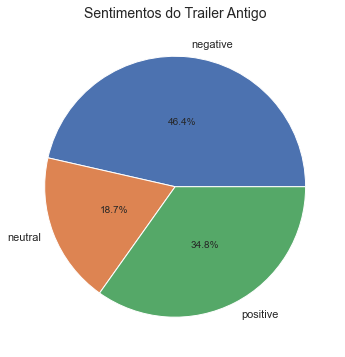

In [207]:
#SENTIMENTOS
data_sent_old = read_old.groupby("sentiment")["sentiment"].count()

pie, ax = plt.subplots(figsize=[10,6])
labels = data_sent_old.keys()
plt.pie(x=data_sent_old, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Sentimentos do Trailer Antigo", fontsize=14);

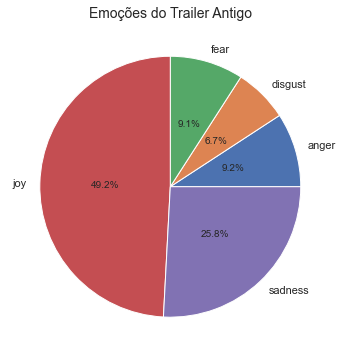

In [208]:
#EMOÇÕES
data_emo_old = read_old.groupby("emotion")["emotion"].count()

pie, ax = plt.subplots(figsize=[10,6])
labels = data_emo_old.keys()
plt.pie(x=data_emo_old, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Emoções do Trailer Antigo", fontsize=14);

In [211]:
##################################### 
#read new comments 
##################################### 
read_new = pd.read_csv("database/trailerNewSentimentEmotion.csv")

read_new = read_new.dropna()

print("Qtd comentários analisados pelo IBM NLP: ", read_new.shape)

Qtd comentários analisados pelo IBM NLP:  (957, 4)


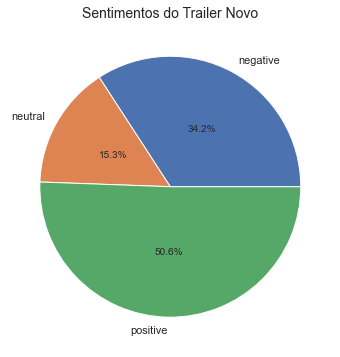

In [212]:
data_sent_new = read_new.groupby("sentiment")["sentiment"].count()

pie, ax = plt.subplots(figsize=[10,6])
labels = data_sent_new.keys()
plt.pie(x=data_sent_new, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Sentimentos do Trailer Novo", fontsize=14);

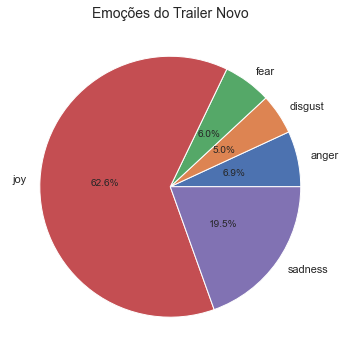

In [213]:
data_emo_new = read_new.groupby("emotion")["emotion"].count()

pie, ax = plt.subplots(figsize=[10,6])
labels = data_emo_new.keys()
plt.pie(x=data_emo_new, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Emoções do Trailer Novo", fontsize=14);

In [6]:
#################################

In [214]:
stop_words = set(STOPWORDS)
string.punctuation

cloud_old = read_old[['sentiment', 'comments']]

top = Counter([item for sublist in cloud_old['comments'].str.lower() for item in sublist.split() if item not in stop_words and item not in string.punctuation ])
table_old = pd.DataFrame(top.most_common(15))
table_old.columns = ['words','count']
table_old.style.background_gradient(cmap='Greens')

#wordcloud.to_file('rafael.png',);

,words,count
0,sonic,274
1,movie,124
2,jim,94
3,trailer,91
4,looks,81
5,look,69
6,reaction,67
7,see,55
8,good,50
9,carrey,50


In [215]:
stop_words = set(STOPWORDS)
string.punctuation

cloud_old = read_new[['sentiment', 'comments']]

top = Counter([item for sublist in cloud_old['comments'].str.lower() for item in sublist.split() if item not in stop_words and item not in string.punctuation ])
table_old = pd.DataFrame(top.most_common(15))
table_old.columns = ['words','count']
table_old.style.background_gradient(cmap='Greens')

,words,count
0,sonic,300
1,movie,162
2,trailer,101
3,see,74
4,love,72
5,one,57
6,looks,53
7,first,51
8,new,49
9,good,49


In [322]:
concact_df = pd.concat([read_old, read_new], ignore_index=True)
concact_df = concact_df.dropna()

In [325]:
columns = ['comments', 'negative', 'positive', 'neutral', 'joy', 'anger', 'disgust', 'sadness', 'fear']
df_transf_new = pd.DataFrame(columns=columns)

In [326]:
for index, row in concact_df.iterrows():
    #sentiment
    inNeg = 0
    inPos = 0
    inNeu = 0
    
    #emotion
    inJoy = 0
    inAng = 0
    inDis = 0
    inSad = 0
    inFea = 0
    
    #sentiment
    if row['sentiment'] == 'negative':
        inNeg = 1
    elif row['sentiment'] == 'positive':
        inPos = 1
    elif row['sentiment'] == 'neutral':
        inNeu = 1
        
    #emotion
    if row['emotion'] == 'joy':
        inJoy = 1
    elif row['emotion'] == 'anger':
        inAng = 1
    elif row['emotion'] == 'disgust':
        inDis = 1    
    elif row['emotion'] == 'sadness':
        inSad = 1    
    elif row['emotion'] == 'fear':
        inFea = 1      
        
    df_transf_new.loc[index] = [row['comments'], inNeg, inPos, inNeu, inJoy, inAng, inDis, inSad, inFea]
    
    #df_transf_new['comments'].loc[index] =    

In [328]:
#### negative value
index = ['joy', 'anger', 'disgust', 'sadness', 'fear']
df_neg_emo = pd.DataFrame(index=index)

result = df_transf_new[['negative', 'positive', 'neutral', 'joy', 'anger', 'disgust', 'sadness', 'fear']]

negative_df = result[result['negative'] == 1]

result = negative_df.groupby("joy")["joy"].sum()[1]
df_neg_emo.at['joy', 'qtd_neg'] = result

result = negative_df.groupby("anger")["anger"].sum()[1]
df_neg_emo.at['anger', 'qtd_neg'] = result

result = negative_df.groupby("disgust")["disgust"].sum()[1]
df_neg_emo.at['disgust', 'qtd_neg'] = result

result = negative_df.groupby("sadness")["sadness"].sum()[1]
df_neg_emo.at['sadness', 'qtd_neg'] = result

result = negative_df.groupby("fear")["fear"].sum()[1]
df_neg_emo.at['fear', 'qtd_neg'] = result

df_neg_emo

,qtd_neg
joy,237.0
anger,108.0
disgust,77.0
sadness,261.0
fear,88.0


In [329]:
#### neutral value
index = ['joy', 'anger', 'disgust', 'sadness', 'fear']
df_neutral_emo = pd.DataFrame(index=index)

result = df_transf_new[['negative', 'positive', 'neutral', 'joy', 'anger', 'disgust', 'sadness', 'fear']]

neutral_df = result[result['neutral'] == 1]

result = neutral_df.groupby("joy")["joy"].sum()[1]
df_neutral_emo.at['joy', 'qtd_neg'] = result

result = neutral_df.groupby("anger")["anger"].sum()[1]
df_neutral_emo.at['anger', 'qtd_neg'] = result

result = neutral_df.groupby("disgust")["disgust"].sum()[1]
df_neutral_emo.at['disgust', 'qtd_neg'] = result

result = neutral_df.groupby("sadness")["sadness"].sum()[1]
df_neutral_emo.at['sadness', 'qtd_neg'] = result

result = neutral_df.groupby("fear")["fear"].sum()[1]
df_neutral_emo.at['fear', 'qtd_neg'] = result

df_neutral_emo

,qtd_neg
joy,151.0
anger,30.0
disgust,21.0
sadness,90.0
fear,33.0


In [330]:
#### positive value
index = ['joy', 'anger', 'disgust', 'sadness', 'fear']
df_positive_emo = pd.DataFrame(index=index)

result = df_transf_new[['negative', 'positive', 'neutral', 'joy', 'anger', 'disgust', 'sadness', 'fear']]

positive_df = result[result['positive'] == 1]

result = positive_df.groupby("joy")["joy"].sum()[1]
df_positive_emo.at['joy', 'qtd_neg'] = result

result = positive_df.groupby("anger")["anger"].sum()[1]
df_positive_emo.at['anger', 'qtd_neg'] = result

result = positive_df.groupby("disgust")["disgust"].sum()[1]
df_positive_emo.at['disgust', 'qtd_neg'] = result

result = positive_df.groupby("sadness")["sadness"].sum()[1]
df_positive_emo.at['sadness', 'qtd_neg'] = result

result = positive_df.groupby("fear")["fear"].sum()[1]
df_positive_emo.at['fear', 'qtd_neg'] = result

df_positive_emo.sum

<bound method DataFrame.sum of          qtd_neg
joy        681.0
anger       16.0
disgust     14.0
sadness     83.0
fear        23.0>

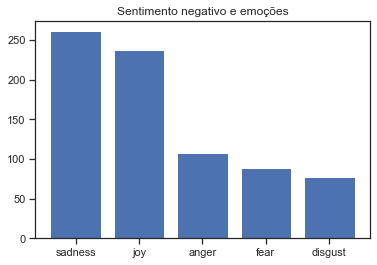

In [331]:
df_neg_emo = df_neg_emo.sort_values(by='qtd_neg', ascending=False)

plt.title("Sentimento negativo e emoções") 

sentiment = (df_neg_emo.index).tolist()
values = df_neg_emo['qtd_neg'].tolist()
plt.bar(sentiment, values)
plt.show()

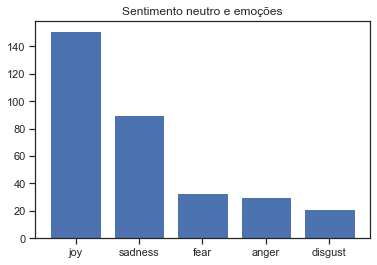

In [333]:
df_neutral_emo = df_neutral_emo.sort_values(by='qtd_neg', ascending=False)

plt.title("Sentimento neutro e emoções") 

sentiment = (df_neutral_emo.index).tolist()
values = df_neutral_emo['qtd_neg'].tolist()
plt.bar(sentiment, values)
plt.show()

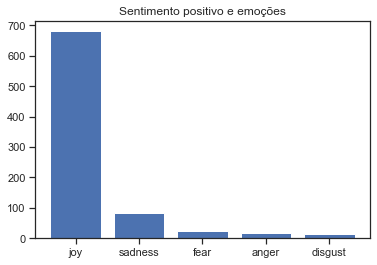

In [332]:
df_positive_emo = df_positive_emo.sort_values(by='qtd_neg', ascending=False)

plt.title("Sentimento positivo e emoções") 

sentiment = (df_positive_emo.index).tolist()
values = df_positive_emo['qtd_neg'].tolist()
plt.bar(sentiment, values)
plt.show()